In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import almscat.Sphere_lib as sphlib
import almscat.Wavelets_lib as wlib

2023-01-18 15:17:47.480392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:17:47.625478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-18 15:17:47.625495: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 15:17:48.236729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
nside = 32

# Load the class to make conversions between alm/map, MW/HPX
HPX_MW = sphlib.HPX_MW_conversion(nside=nside)

####### PARAMETERS
J_min = 0 # First wavelet scale to be used.
B = 2     # Scale factor between consecutive wavelet scales (2 for dyadic).
N = 3    # Number of orientations, N must be odd
L = HPX_MW.L
print(L)

# Number of scales
J = wlib.get_J_number_of_wavelets(B, L, J_min)
print('Number of wavelets:', J)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
96
Number of wavelets: 7


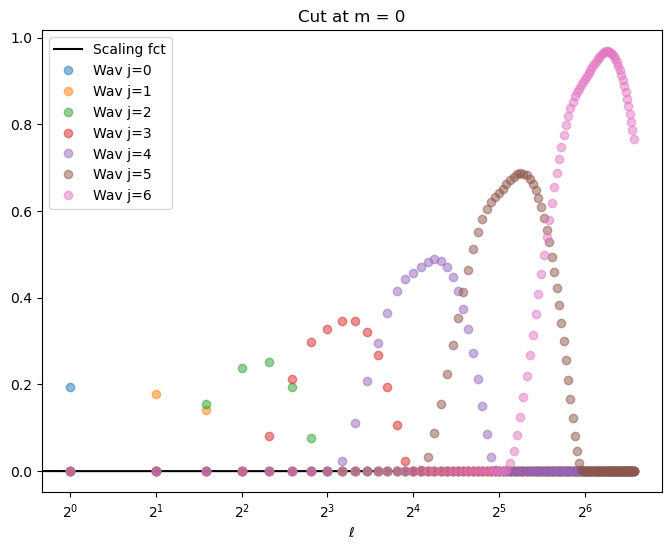

In [3]:
###### Build the wavelets
scaling_ln, wavelet_ln = wlib.make_directional_wavelets(nside, B, N, J_min, HPX_MW.m_MW, doplot=True)

In [4]:
# Make a MW map
wavelet_map = HPX_MW.alm2map_MW(wavelet_ln)
print(L, 2*L-1, wavelet_map.shape)

96 191 (7, 96, 191)


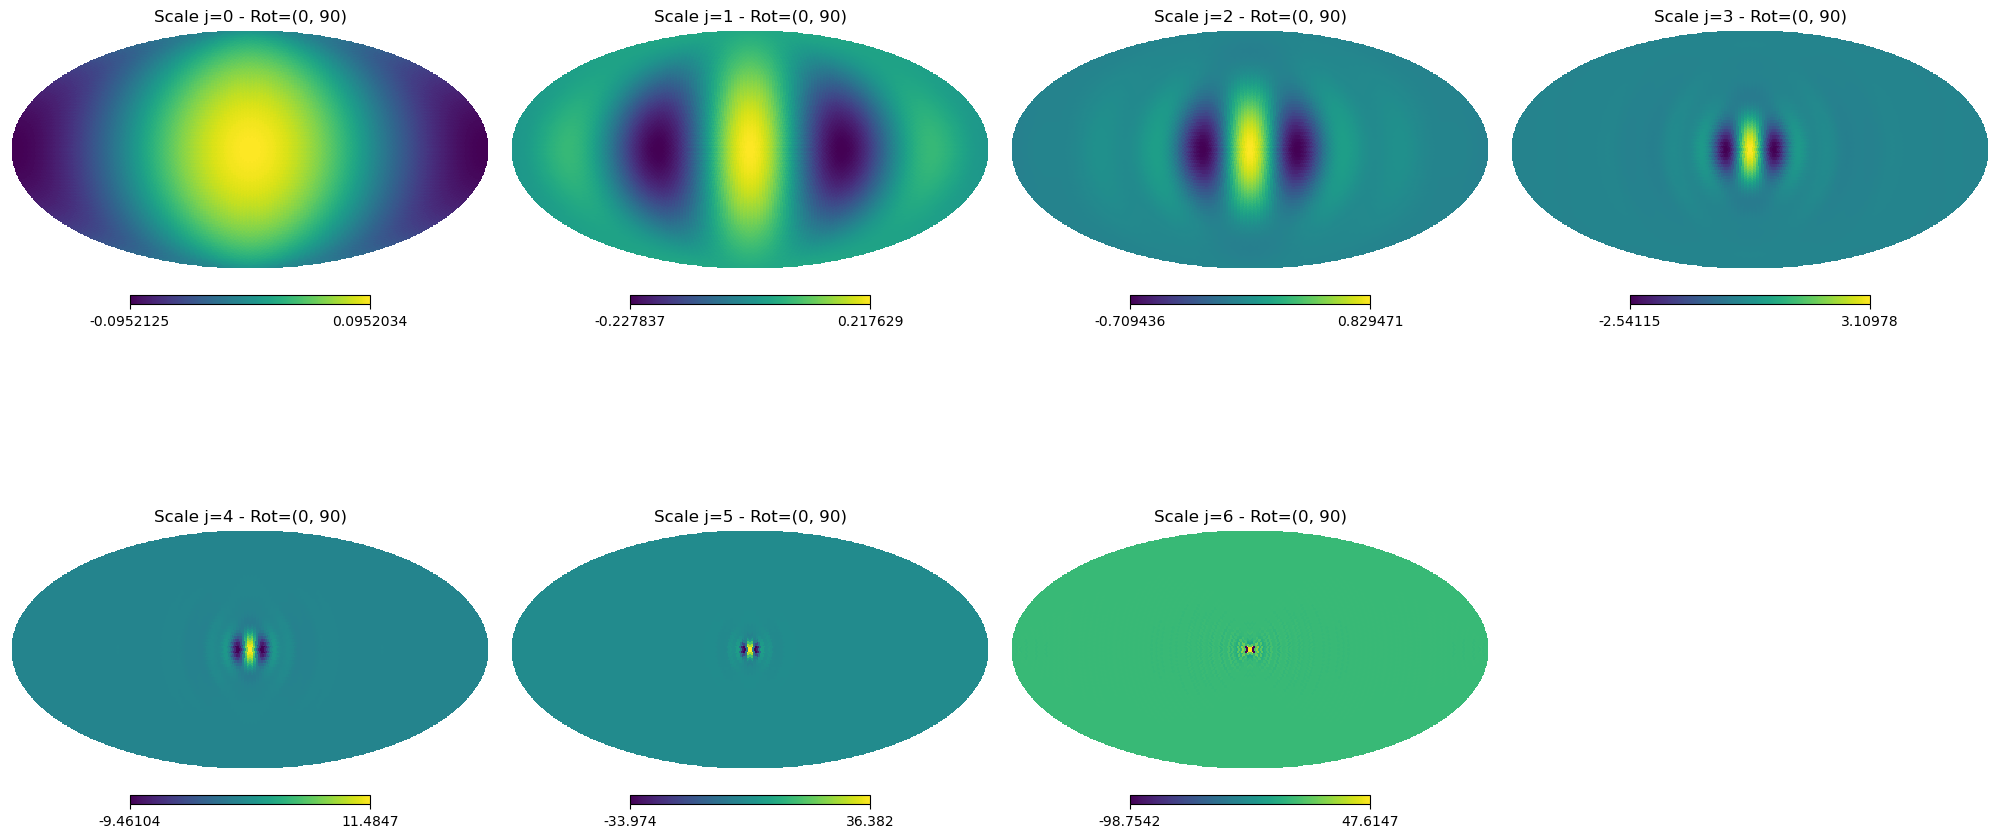

In [5]:
# Plot all scales
# Go to Healpix map just to be able to rotate
plt.figure(figsize=(20, 10))
rot = (0, 90)
for idx in range(J):
    wavelet_map_hpx = HPX_MW.MW_map2Hpx_map(wavelet_map[idx, :, :])
    hp.mollview(wavelet_map_hpx, sub=(2, 4, idx+1), rot=rot, title=f'Scale j={idx} - Rot={rot}')

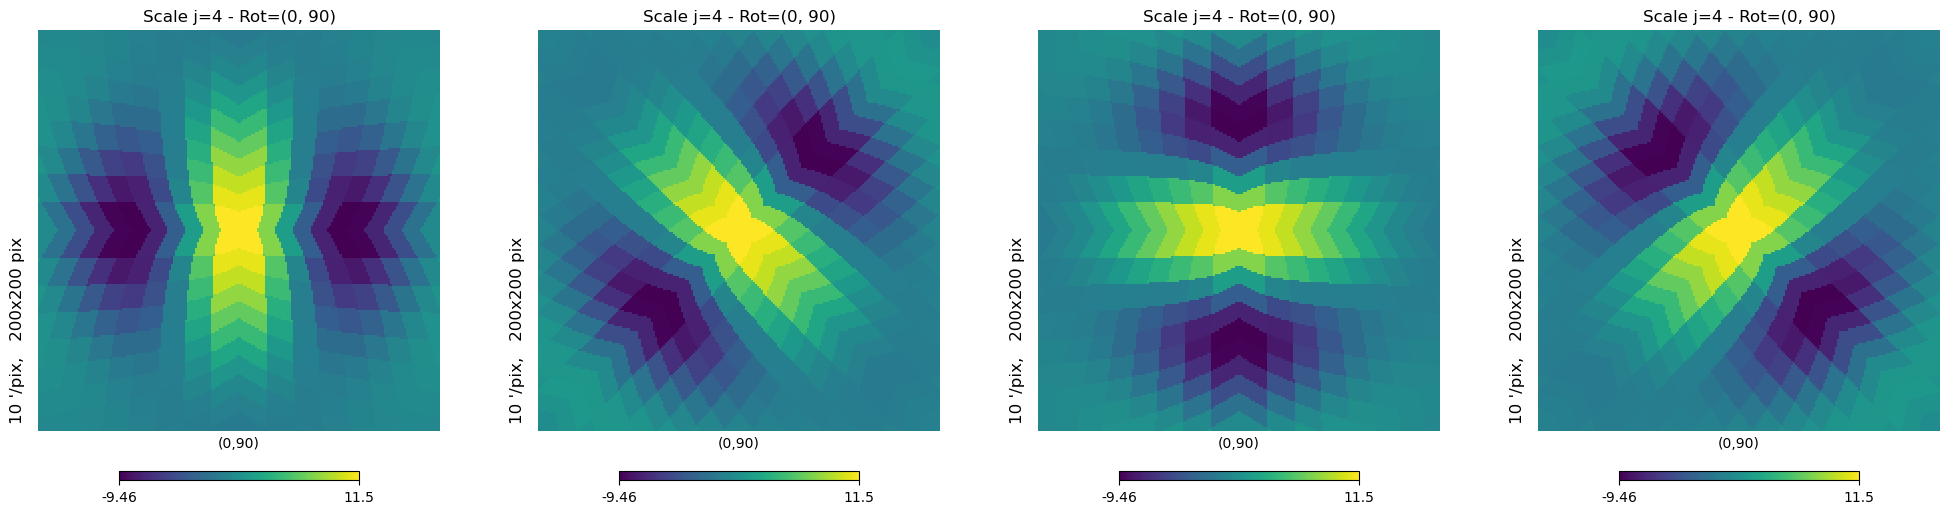

In [6]:
# Select a scale
idx = 4
wavelet_map_hpx = HPX_MW.MW_map2Hpx_map(wavelet_map[idx, :, :])

norient = 4

wavelets_gnom = np.zeros((200, 200, norient))
plt.figure(figsize=(20, 5))
for i, r in enumerate([0, 45, 90, 135]):
    wavelets_gnom[:, :, i] = hp.gnomview(wavelet_map_hpx, sub=(1, 4, i+1), reso=10, rot=(0, 90, r), title=f'Scale j={idx} - Rot={rot}', return_projected_map=True)

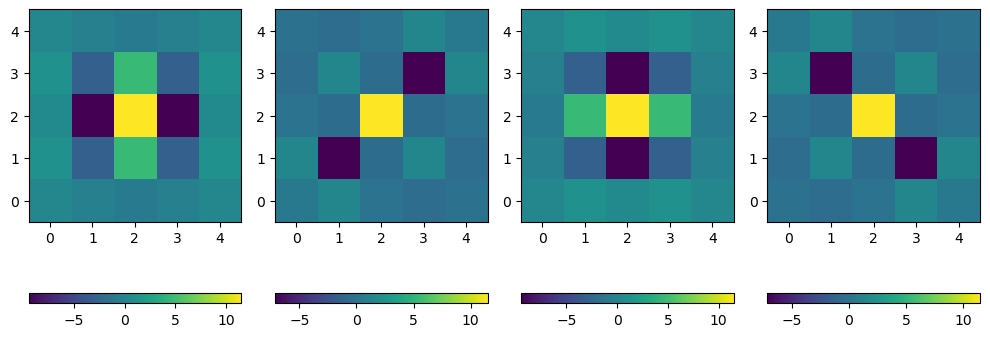

In [7]:
import scipy
kersize = 5

wavelets = np.zeros((kersize, kersize, norient))
for i in range(4):
    wavelets[:, :, i] = scipy.ndimage.zoom(wavelets_gnom[:, :, i], kersize / 200)

fig, axs = plt.subplots(1, norient, figsize=(10, 5))
axs = axs.ravel()

for i in range(4):
    ax = axs[i]
    im = ax.imshow(wavelets[:, :, i], origin='lower')
    fig.colorbar(im, orientation='horizontal')
fig.tight_layout()

# Make a FOSCAT convolution with this wavelet

In [8]:
import foscat.FoCUS as FOC

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 16  # NSIDE

# !!! No mask
nmasks = 1
mask=np.ones([1, 12*nout**2])

im = np.random.randn(12 * nout**2)

In [10]:
fc = FOC.FoCUS(NORIENT=4,  # define the number of wavelet orientation
               KERNELSZ=5,  # define the kernel size (here 3x3)
               healpix=True,  # use the healpix pixelisation
               OSTEP=0,  # get very large scale (nside=1)
               TEMPLATE_PATH=scratch_path)

# Add the masks
fc.add_mask(mask)

# compute amplitude to normalize the dynamic range
ampmap = 1 / im[mask[0] > 0.9].std()

# convert data in tensor for focus (should be done internally)
data = fc.convimage(ampmap * im)

          START FOSCAT CONFIGURATION
Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==
Use 1 masks


In [11]:
# Initialize the learning and initialize the tensor to be synthesized
# guess = np.random.randn(12 * nout * nout)  # Guess starting map (gaussian noise)
# ldata = fc.init_synthese(guess)  # Tensor (guess map) [1, Npix, 1, 1]
# print(ldata)

In [12]:
def do_conv(image):
    c,s = fc.get_ww()
    # Replace by the new wavelets
    c[:, :] = np.reshape(wavelets, newshape=(kersize*kersize, norient))
    s[:, :] = np.reshape(wavelets, newshape=(kersize*kersize, norient))
    lout=int(np.sqrt(image.shape[0]//12))
    idx=np.load('%s/W%d_%d_IDX.npy'%(fc.TEMPLATE_PATH,fc.KERNELSZ**2,lout))
    res=np.zeros([12*lout*lout,fc.NORIENT],dtype='complex')

    res[:,:].real=np.sum(image[idx].reshape(12*lout*lout,fc.KERNELSZ**2,1)
                         *c.reshape(1,fc.KERNELSZ**2,fc.NORIENT),1)
    res[:,:].imag=np.sum(image[idx].reshape(12*lout*lout,fc.KERNELSZ**2,1)
                         *s.reshape(1,fc.KERNELSZ**2,fc.NORIENT),1)
    return(res)

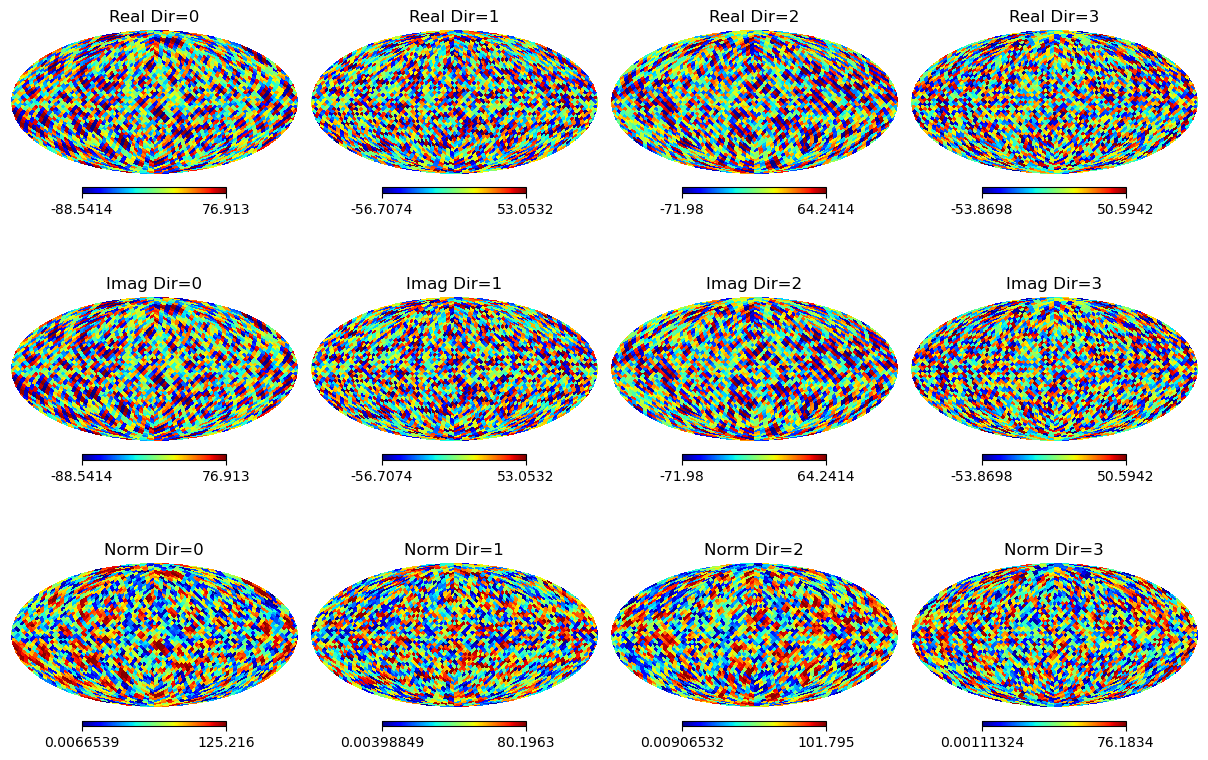

In [13]:
res = do_conv(im)

plt.figure(figsize=(12, 8))
for i in range(4):
    hp.mollview(res[:, i].real, cmap='jet', hold=False, sub=(3, 4, 1 + i), nest=True, title='Real Dir=%d' % (i),
                norm='hist')
    hp.mollview(res[:, i].imag, cmap='jet', hold=False, sub=(3, 4, 5 + i), nest=True, title='Imag Dir=%d' % (i),
                norm='hist')
    hp.mollview(abs(res[:, i]), cmap='jet', hold=False, sub=(3, 4, 9 + i), nest=True, title='Norm Dir=%d' % (i),
                norm='hist')

Real Part of the wavelet coefficients
[[ 0.24076296 -0.30010578 -0.71432063 -0.30012564  0.24078257]
 [ 1.14772935 -3.00422672  4.64533109 -3.00415196  1.14770706]
 [ 0.54318205 -9.46121361 11.4846609  -9.46121933  0.54318232]
 [ 1.14770658 -3.00415135  4.64533229 -3.00422957  1.14772971]
 [ 0.24078238 -0.30012558 -0.71432069 -0.30010689  0.24076262]]
Imaginary Part of the wavelet coefficients
[[ 0.24076296 -0.30010578 -0.71432063 -0.30012564  0.24078257]
 [ 1.14772935 -3.00422672  4.64533109 -3.00415196  1.14770706]
 [ 0.54318205 -9.46121361 11.4846609  -9.46121933  0.54318232]
 [ 1.14770658 -3.00415135  4.64533229 -3.00422957  1.14772971]
 [ 0.24078238 -0.30012558 -0.71432069 -0.30010689  0.24076262]]


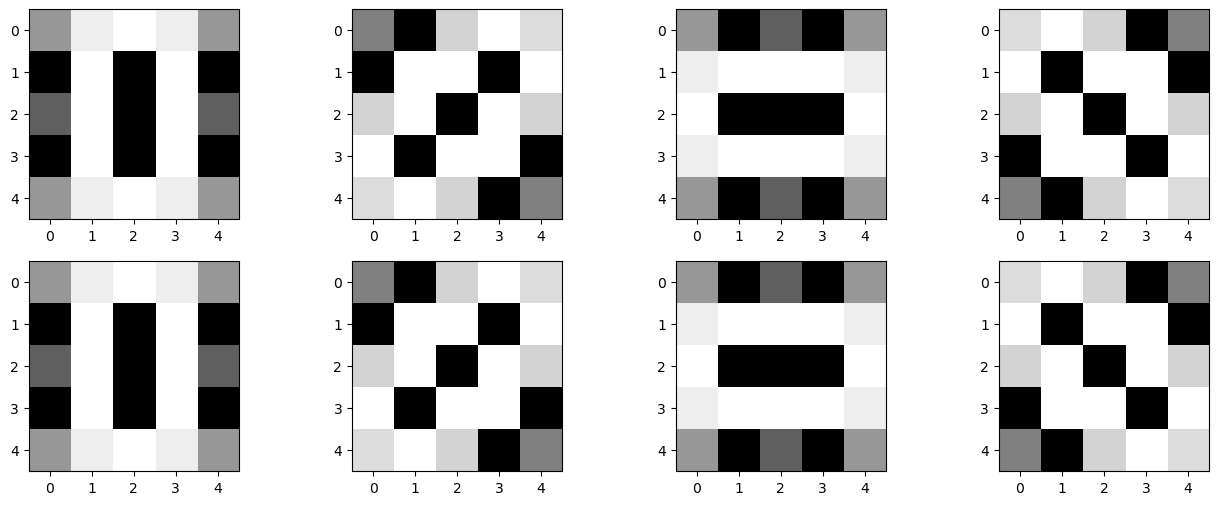

In [14]:
c, s = fc.get_ww()
kernel = int(np.sqrt(c.shape[0]))
print('Real Part of the wavelet coefficients')
print(c[:, 0].reshape(kernel, kernel))
print('Imaginary Part of the wavelet coefficients')
print(s[:, 0].reshape(kernel, kernel))
fc.plot_ww()

In [15]:
spectrum_real = np.zeros((3*nout, norient))
spectrum_imag = np.zeros((3*nout, norient))
for i in range(norient):
    spectrum_real[:, i] = hp.anafast(res[:, i].real)
    spectrum_imag[:, i] = hp.anafast(res[:, i].imag)

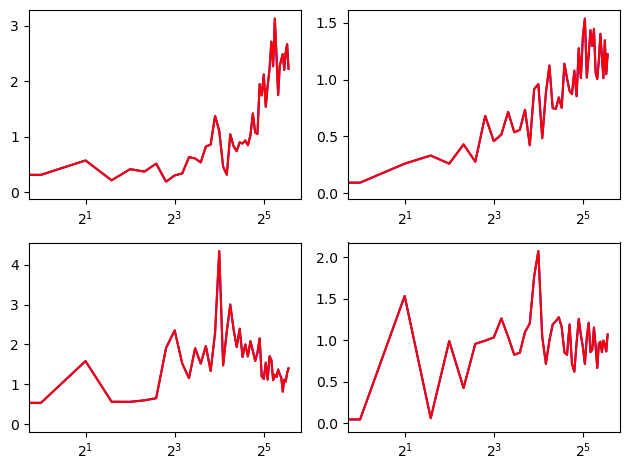

In [16]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()

for i in range(norient):
    ax = axs[i]
    ax.plot(spectrum_real[:, i], 'b')
    ax.plot(spectrum_imag[:, i], 'r')
    ax.set_xscale('log', base=2)

fig.tight_layout()
